In [1]:
from IPython.display import display
import mangoes
import nltk
import string 
import pprint 
import os 
import datetime 

Read more for 

https://github.com/UniversalDependencies/UD_English-EWT


In [ ]:
today = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")

In [ ]:
OUTPUT_PATH = os.path.join(os.path.abspath(''), "output/{}".format(today))
if not os.path.exists(OUTPUT_PATH):
    print("made a dir: ", OUTPUT_PATH)
    os.makedirs(OUTPUT_PATH)   

In [ ]:
today

# Build Embedding 
### Corpus

In [2]:
UD_English_EWT = "../../UD_English-EWT-master/corpus"
# UD_English_EWT =  "../../UD_English-EWT-master/corpus/en_ewt-ud-train.conllu"

In [3]:
corpus = mangoes.Corpus(UD_English_EWT, 
                        reader=mangoes.corpus.CONLLU, 
                        language="English",
                        lower=True, 
                        ignore_punctuation=False)

Counting words: 0it [00:00, ?it/s]

In [4]:
print("{} sentences, {} words".format(corpus.nb_sentences, corpus.size))

16622 sentences, 254829 words


In [5]:
corpus.describe()

Name: ../../UD_English-EWT-master/corpus
Language: English
Reader: <class 'mangoes.utils.reader.ConllUSentenceGenerator'>
Parameters:
	- lower : True
	- digit : False
	- ignore_punctuation : False
Size:
	- sentences: 16622
	- total number of tokens: 254829
	- number of unique tokens: 23316


In [6]:
# Save corpus 
# corpus_metadata = os.path.join(os.path.abspath(''), "output/{}/.corpus".format(today))
# print("Saved Corpus")
# corpus.save_metadata(corpus_metadata)

NameError: name 'today' is not defined

In [ ]:
# or load 
# corpus = mangoes.Corpus.load_from_metadata(corpus_metadata)

### Vocabulary
#### Target Words

In [7]:
stopwords_filter_lemma = mangoes.corpus.remove_elements(nltk.corpus.stopwords.words('english'), attribute="lemma")

Option 1: Use Lemma and POS as targetwords

In [8]:
# target_vocabulary = corpus.create_vocabulary(attributes=("lemma","POS"), 
#                                               filters = [ stopwords_filter_lemma, 
#                                                          mangoes.corpus.remove_most_frequent(100),
#                                                          mangoes.corpus.remove_least_frequent(2)])

Option 2:

In [9]:
# option for only keeping lemma 
stopwords_filter = mangoes.corpus.remove_elements(nltk.corpus.stopwords.words('english'))

target_vocabulary = corpus.create_vocabulary(attributes="lemma", 
                                              filters = [ stopwords_filter, 
                                                         mangoes.corpus.remove_most_frequent(100),
                                                         mangoes.corpus.remove_least_frequent(2)])

Check vocabulary 

In [10]:
target_vocabulary[:10]

['seem',
 'believe',
 'anything',
 'able',
 'care',
 'might',
 'add',
 'file',
 'hear',
 'United']

In [11]:
len(target_vocabulary)

8598

#### Context Words

In [12]:
context_vocabulary = corpus.create_vocabulary(attributes=("lemma","POS"), 
                                              filters = [ stopwords_filter_lemma])

In [13]:
context_vocabulary[:15]

[Token(lemma='.', POS='PUNCT'),
 Token(lemma=',', POS='PUNCT'),
 Token(lemma='I', POS='PRON'),
 Token(lemma='"', POS='PUNCT'),
 Token(lemma='-', POS='PUNCT'),
 Token(lemma='?', POS='PUNCT'),
 Token(lemma=')', POS='PUNCT'),
 Token(lemma='(', POS='PUNCT'),
 Token(lemma="'s", POS='PART'),
 Token(lemma='would', POS='AUX'),
 Token(lemma=':', POS='PUNCT'),
 Token(lemma='!', POS='PUNCT'),
 Token(lemma='go', POS='VERB'),
 Token(lemma='get', POS='VERB'),
 Token(lemma='time', POS='NOUN')]

In [14]:
len(context_vocabulary)

19217

### Context 

In [15]:
dependency_context = mangoes.context.DependencyBasedContext(entity=("lemma","POS"), 
                                                            labels=True,
                                                            collapse=True, 
                                                            vocabulary=context_vocabulary,
                                                            deprel_inverse=False)

In [ ]:
# # save vocabularies 
# target_vocabulary_file_name = "vocabulary_{}_target_words".format(len(target_vocabulary))
# context_vocabulary_file_name = "vocabulary_{}_context_words".format(len(context_vocabulary))

# # save
# target_vocabulary.save(os.path.join(os.path.abspath(''), "output/{}".format(today)), name=target_vocabulary_file_name)
# context_vocabulary.save(os.path.join(os.path.abspath(''), "output/{}".format(today)), name=context_vocabulary_file_name)

In [ ]:
# load vocabs
# target_vocabulary = mangoes.Vocabulary.load("output", target_vocabulary_file_name)
# context_vocabulary = mangoes.Vocabulary.load("output", context_vocabulary_file_name)

### Cooccurrence Matrix 

In [16]:
coocc_count = mangoes.counting.count_cooccurrence(corpus,  
                                                target_vocabulary, 
                                                context=dependency_context,
                                                )

coocc_count.pprint(display=display)

,"{'lemma': 'term', 'POS': 'NOUN'}/case_for","{'lemma': 'Bush', 'POS': 'PROPN'}/nsubj","{'lemma': 'term', 'POS': 'NOUN'}/obl","{'lemma': 'Jennifer', 'POS': 'PROPN'}/obj","{'lemma': '.', 'POS': 'PUNCT'}/punct","{'lemma': 'replace', 'POS': 'VERB'}/advcl","{'lemma': ',', 'POS': 'PUNCT'}/punct","{'lemma': 'Anderson', 'POS': 'PROPN'}/flat","{'lemma': 'M.', 'POS': 'PROPN'}/flat","{'lemma': 'judge', 'POS': 'NOUN'}/case_as",...,"{'lemma': 'attest', 'POS': 'VERB'}/xcomp","{'lemma': 'dress', 'POS': 'NOUN'}/case_to","{'lemma': 'observation', 'POS': 'NOUN'}/case_with","{'lemma': 'observation', 'POS': 'NOUN'}/obl","{'lemma': 'one', 'POS': 'NOUN'}/case_as","{'lemma': 'shred', 'POS': 'VERB'}/amod","{'lemma': 'wheel', 'POS': 'NOUN'}/case_over","{'lemma': 'steering', 'POS': 'NOUN'}/compound","{'lemma': 'tire', 'POS': 'NOUN'}/conj","{'lemma': 'model', 'POS': 'NOUN'}/case_for"
seem,0,0,0,0,50,0,27,0,0,0,...,1,0,0,0,0,0,0,0,0,0
believe,0,0,0,0,38,0,14,0,0,0,...,0,0,0,0,0,0,0,0,0,0
anything,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
able,0,1,0,0,33,0,16,0,0,0,...,0,0,0,0,0,0,0,0,0,0
care,0,0,0,0,1,0,6,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tote,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Zahav,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hummus,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
flatbread,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
coocc_count.shape

(8598, 30065)

In [18]:
i = 12
print("target word: ", target_vocabulary[i])
print("close words")
pprint.pprint(coocc_count.get_closest_words(target_vocabulary[i], 10))

target word:  excellent
close words
[('terrible', 0.17497135267460984),
 ('yes', 0.17800945917981448),
 ('i.e', 0.18651078318003933),
 ('sigh', 0.18651078318003933),
 ('9', 0.18651078318003933),
 ('7th', 0.18651078318003933),
 ('Saratoga', 0.18651078318003933),
 ('sooooo', 0.18651078318003933),
 ('definitely', 0.18651078318003933),
 ('logical', 0.18651078318003933)]


### Weighting 

In [19]:
ppmi = mangoes.weighting.PPMI()
svd = mangoes.reduction.SVD(dimensions=300)

In [20]:
embeddings = mangoes.create_representation(coocc_count, weighting=ppmi, reduction=svd)

In [21]:
embeddings.pprint(display=display)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
seem,-2.323091e-01,-3.123906e-02,4.460554e-01,2.605477e-01,1.617567e-01,-2.134446e-01,3.301098e-01,-4.517733e-01,2.789577e-01,6.410331e-02,...,3.835996e+01,2.139082e+01,5.124041e+00,7.898903e-01,-1.460007e+01,-4.215253e+00,1.327555e+00,2.819673e+00,7.862878e+00,9.884551e+00
believe,4.670710e-01,-4.823871e-01,4.582056e-01,-8.603887e-01,-3.739640e-03,2.857878e-01,2.190938e-01,5.924154e-02,-1.839921e-01,3.248780e-01,...,-2.514526e-01,5.833991e-01,5.183735e-01,-2.163536e+00,-3.509625e+00,-8.514573e-01,3.503283e+00,2.194469e+00,3.351182e+00,5.779144e+00
anything,5.914615e-01,-2.116312e+00,-3.473476e+00,-8.945709e-01,-4.691077e-01,3.829800e-01,6.785359e-03,5.597293e-01,4.856367e+00,3.375973e+00,...,-4.407506e-01,-5.733108e-02,5.725199e-02,4.583025e-02,4.527053e-01,2.494092e+00,-1.115463e-01,-1.792004e+00,-1.288714e+00,2.590330e+00
able,-3.947741e-01,5.268036e-01,-1.703181e-01,3.563200e-01,-4.190141e-01,-7.499829e-01,-8.604876e-01,-2.843930e-01,-1.924050e-01,-4.537059e-01,...,3.333108e+00,6.929263e+00,2.973355e+00,-4.744515e+00,-9.976908e+00,-2.717730e+00,1.510306e+00,2.953302e+00,6.033896e+00,7.838098e+00
care,-6.713620e-01,4.539825e-01,1.116770e-01,2.129513e-01,-3.707956e-01,-8.332346e-01,-1.863151e+00,5.781816e-01,-6.871119e-03,-5.970627e-01,...,8.093769e-02,7.183185e-01,-2.100846e-01,-3.191428e-01,-7.572543e-01,2.526095e+00,-4.731759e-01,-2.485176e+00,1.172508e+00,5.071778e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tote,1.981233e-01,1.809466e-01,1.422407e-01,-1.476407e-01,1.417363e-01,-5.763749e-02,-2.337785e-02,6.376074e-02,-3.091960e-01,-1.100031e-01,...,5.210168e-02,3.179080e-02,2.073043e-02,-4.762493e-02,-1.016618e-01,-2.128208e-01,2.976525e-02,-2.059741e-01,-2.591276e-02,4.377996e-01
Zahav,-3.012875e-17,-1.343387e-17,8.137631e-18,2.970329e-17,5.989322e-17,3.713411e-17,5.075660e-17,-2.195983e-17,4.288570e-17,-1.663388e-17,...,-1.587771e-16,2.389351e-17,-5.978562e-17,-1.341691e-17,4.560376e-17,2.862470e-17,1.190316e-17,-7.149233e-17,1.333266e-16,-5.339878e-17
hummus,1.089609e-16,4.402271e-17,-3.441570e-17,-1.142684e-16,-2.364793e-16,-1.417058e-16,-2.015579e-16,9.198145e-17,-1.692884e-16,7.066648e-17,...,6.476261e-16,-1.065973e-16,2.389625e-16,7.385829e-17,-1.853268e-16,-1.186325e-16,-4.705153e-17,3.301766e-16,-5.391743e-16,1.893008e-16
flatbread,3.862957e-17,1.598907e-17,-1.208324e-17,-4.084016e-17,-8.652033e-17,-4.954304e-17,-7.001866e-17,3.297620e-17,-6.028072e-17,2.634319e-17,...,2.255860e-16,-3.920997e-17,8.528038e-17,2.185174e-17,-6.533462e-17,-4.788861e-17,-1.271927e-17,9.990010e-17,-1.769843e-16,6.467519e-17


In [23]:
# Save the embeddings 
# embedding_path = os.path.join(OUTPUT_PATH,
#                               "embeddings/ppmi_svd_{}target_words_deprel".format(len(target_vocabulary)))

In [ ]:
# embeddings.save(embedding_path)

In [ ]:
# load embedding 
# embeddings = mangoes.Embeddings.load(embedding_path)

# Explore Embedding 

In [24]:
import pandas as pd 

### Closest Words 

#### Similarities 

In [25]:
sims = {0: "cityblock",
        1: "cosine", 
        2: "euclidean", 
        3: "l1", 
        4:"l2", 
        5:"manhattan",
        6:"braycurtis", 
        7:"canberra", 
        8:"chebyshev", 
        9:"correlation", 
        10:"dice", 
        11:"hamming", 
        12:"jaccard", 
        13:"kulsinski", 
        14:"mahalanobis", 
       15: "minkowski", 
       16: "rogerstanimoto", 
       17: "russellrao", 
       18: "seuclidean", 
        19:"sokalmichener", 
        20:"sokalsneath", 
       21: "sqeuclidean", 
       22: "yule"}


In [26]:
i = 2
nb = 5

In [27]:
result = {word: pd.Series([w for w, _ in embeddings.get_closest_words(word, nb=nb, metric=sims[i])], index=range(1,nb+1))
          for word in embeddings.words[100:200:10]}
print(f"similarity measure: {sims[i]}")
print(pd.DataFrame(result).transpose())

similarity measure: euclidean
                 1              2             3             4             5
process     orphan  appropriation           bid     technique         curve
rate         speed        revenue       routine       compete         trail
hold     retaliate          touch        kidnap       feature          mate
quality       beer          grade    atmosphere        cookie        burger
6            funny             13            33          pg&e             8
write        reply       transmit        stifle         shake      decrease
happy      pleased      satisfied  disappointed  satisfactory  dissatisfied
note         touch        summary        detect          cite       profile
fun           beer           luck       florist     nightlife           cod
along         10.2           else       Disease          Oval  occasionally


### Analogies 

In [41]:
# Check what words are available 
question = "king queen male"
ans = "female"
for w in (question.split() + [ans]):
    try:
        embeddings.words.word_index[w]
        print(f"'{w}' exists")
    except KeyError:
        print(f"'{w}'  doesn't exist in embedding")

'king' exists
'queen' exists
'male' exists
'female' exists


In [42]:
# You can resolve analogy according to a representation using the analogy() method
# Here, we will display the results of some examples :
for analogy in [question]:
    print(analogy, '->', embeddings.analogy(analogy,).using_cosadd[0])
    print(analogy, '->', embeddings.analogy(analogy).using_cosmul[0])

king queen male -> serving
king queen male -> female


### Visualization

<IPython.core.display.Javascript object>


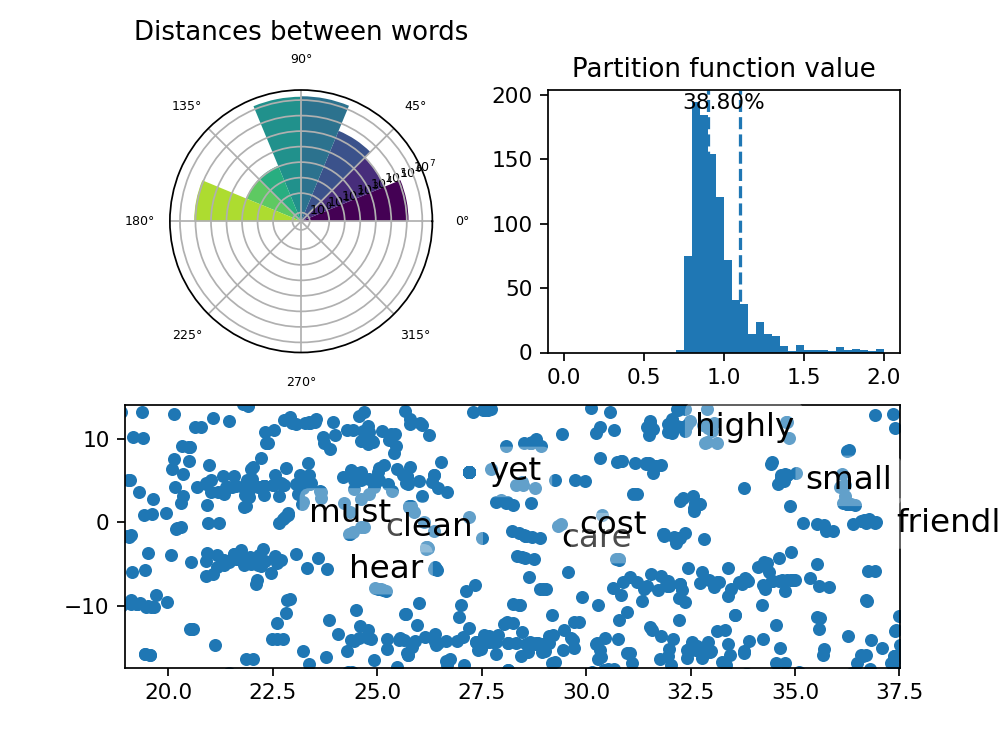

/home/namiakazawa/Desktop/mangoes/mangoes/evaluation/statistics.py:112: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cosines[[cosines > 1]] = 1
/home/namiakazawa/Desktop/mangoes/mangoes/evaluation/statistics.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cosines[[cosines < -1]] = -1


In [45]:
%matplotlib notebook
import matplotlib.pyplot as plt
import mangoes.visualize
plt.figure()

# 1. distances between the words
ax = plt.subplot(221, projection='polar')
mangoes.visualize.plot_distances(embeddings, ax)

# 2. isotropy
ax = plt.subplot(222)
mangoes.visualize.plot_isotropy(embeddings, ax)

# 3. t-sne
plt.subplot(212)
mangoes.visualize.plot_tsne(embeddings)

plt.show()


# Evalutaion 

In [ ]:
# # Evaluate
import mangoes.evaluation.analogy

google_dataset = mangoes.evaluation.analogy.GOOGLE
msr_dataset = mangoes.evaluation.analogy.MSR

analogy_evaluation = mangoes.evaluation.analogy.Evaluation(embeddings, google_dataset, msr_dataset)
print(analogy_evaluation.get_report())